In [1]:
from unet import unet_constructor as GUnet
import dataloader as dataloader
from loss import dice_loss, cross_entropy_loss, random_cross_entropy
import transforms as t
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision.transforms as tt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import pickle
import skimage.io as io
import os
import os.path
import time




In [2]:
data = dataloader.stack(path='./Data/train',
                        joint_transforms=[t.to_float(),
                                          t.reshape(),
                                          t.nul_crop(rate=.85),
                                          t.random_crop([256, 256, 24]),
                                          t.random_rotate(),
                                          #t.random_affine()
                                          ],
                        image_transforms=[
                                          t.drop_channel(.8), 
                                          t.random_gamma((.7, 1.3)),
                                          t.random_intensity(),
                                          t.spekle(0.00001),
                                          t.clean_image(),
                                          t.normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
                                          ]
                        )

val_data = dataloader.stack(path='./Data/train',
                        joint_transforms=[t.to_float(),
                                          t.reshape(),
                                          t.random_crop([512, 512, 30]),
                                          t.random_rotate(90),
                                          #t.random_affine
                                          ],
                        image_transforms=[
                                          #t.random_gamma((.8,1.2)),
                                          #t.spekle(),
                                          t.normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
                                          ]
                        )



In [3]:
for image, mask, pwl in data:
    print(f'TYPE: {image.dtype}, {mask.dtype}, {pwl.dtype}')
    print(f'TYPE: {image.float().max()}, {mask.float().max()}, {pwl.float().max()}')
    print(f'TYPE: {image.float().min()}, {mask.float().min()}, {pwl.float().min()}')

TYPE: torch.float16, torch.float16, torch.float16
TYPE: 0.293212890625, 0.99609375, 10.15625
TYPE: -1.0, 0.0, 0.0
TYPE: torch.float16, torch.float16, torch.float16
TYPE: 0.1552734375, 0.99609375, 10.15625
TYPE: -1.0, 0.0, 0.0
TYPE: torch.float16, torch.float16, torch.float16
TYPE: 1.0, 0.99609375, 10.15625
TYPE: -1.0, 0.0, 0.0
TYPE: torch.float16, torch.float16, torch.float16
TYPE: 1.0, 0.99609375, 10.15625
TYPE: -1.0, 0.0, 0.0
TYPE: torch.float16, torch.float16, torch.float16
TYPE: 1.0, 0.99609375, 10.15625
TYPE: -1.0, 0.0, 0.0
TYPE: torch.float16, torch.float16, torch.float16
TYPE: 1.0, 0.99609375, 10.15625
TYPE: -1.0, 0.0, 0.0
TYPE: torch.float16, torch.float16, torch.float16
TYPE: 0.2432861328125, 0.99609375, 10.15625
TYPE: -1.0, 0.0, 0.0
TYPE: torch.float16, torch.float16, torch.float16
TYPE: 0.6865234375, 0.99609375, 10.15625
TYPE: -1.0, 0.0, 0.0
TYPE: torch.float16, torch.float16, torch.float16
TYPE: 1.0, 0.99609375, 10.15625
TYPE: -1.0, 0.0, 0.0
TYPE: torch.float16, torch.float

In [4]:
device = 'cuda:0'

test = GUnet(image_dimensions=3,
             in_channels=4,
             out_channels=1,
             #feature_sizes=[16,32,64,128],
             feature_sizes=[32, 64, 128],
             kernel={'conv1': (8, 8, 2), 'conv2': (8, 8, 1)},
             upsample_kernel=(8, 8, 2),
             max_pool_kernel=(2, 2, 1),
             upsample_stride=(2, 2, 1),
             dilation=1,
             groups=2).to(device)


test = test.type(torch.float)

# image, mask, pwl = data[0]

# out = test.forward(image.float().to(device))
# out_loss = dice_loss(out, mask.to(device))#, pwl.float().to('cuda'))

sd = None

In [ ]:
#test.load('May14_chris-MS-7C37_2.unet') # <- BEST YET

sd = 'Jun21_chris-MS-7C37_1.unet'
test.load(sd)
test.cuda()
test.train()
print('Yeet')

In [5]:
lr = 0.01
gamma = .75
weight_cel = 1.3
weight_dice = 1
cel_z_weighting_method = None
momentum = .99
nesterov=True
timestart = time.asctime()

device = 'cuda:0'                 

epoch_loss = []
running_loss = []
epoch = 0 


In [6]:
writer = SummaryWriter(comment=timestart)

In [7]:
optimizer = torch.optim.Adam(test.parameters(), lr = lr)
#optimizer = torch.optim.SGD(test.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)

scheduler_1 = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)
scheduler_2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=100)


In [8]:
while True:  # loop over the dataset multiple times
    epoch_loss_dice=[]
    epoch_loss_BCE=[]
    epoch_loss_joint=[]
    for i in range(len(data)):
        image, mask, pwl  = data[i]
        
        optimizer.zero_grad()
        
        out = test(image.float().to('cuda'))


        #out_loss = ((np.cos(2*np.pi * (epoch/100))+1)/4 + .2) * cross_entropy_loss(out, mask.to('cuda'), pwl.to('cuda'), 5) +\
        #           dice_loss(out, mask.to('cuda'))
        #out_loss = weight_cel * cross_entropy_loss(out, mask.to('cuda'), pwl.to('cuda'), weight=cel_z_weighting_method) +\
        #           weight_dice * dice_loss(out, mask.to('cuda'))
        out_loss = weight_cel * random_cross_entropy(out, mask.to('cuda'), pwl.to('cuda'), 20000) +\
                   weight_dice * dice_loss(out, mask.to('cuda'))
        
        
        if torch.isnan(out_loss):
            print(cross_entropy_loss(out, mask.to('cuda'), pwl.to('cuda')))
            print(dice_loss(out, mask.to('cuda')))
            print(torch.isnan(mask.float()).any(), torch.isnan(image.float().any()), torch.isnan(pwl.float()).any())
            print(out.shape)
            raise ValueError
        
        del out
        
        epoch_loss_joint.append(out_loss.item())
        
        print(f'\r\033[32mEpoch: \033[0m{epoch} |',end='')
        print(f' JOINT |', end='')
        print(f' {i} |',end='')
        print(f' \033[35mPOL: \033[0m{str(running_loss)[0:8]} -->', end='')
        print(f' \033[35mOL: \033[0m{str(out_loss.item())[0:8]}', end='')

        out_loss.backward()
        optimizer.step()
        

        running_loss = out_loss.item()
        
        del out_loss, mask, pwl 
        
    to_tb = np.array(epoch_loss_joint).sum()/len(epoch_loss_joint)
    writer.add_scalar('Cyclic Joint Loss Train', to_tb, epoch)
    epoch_loss.append(to_tb)
    epoch += 1

 


Epoch: 660 | JOINT | 7 | POL: 1.174520 --> OL: 0.5480471

KeyboardInterrupt: 

In [9]:
savename = 'Jun23_chris-MS-7C37_1.unet'

if os.path.exists(savename):
    raise NameError('Save file of this path already exists.')

hyperparameters =  {'lr': lr,
                    'epoch_final': epoch,
                    'weight_cross_entropy_loss':weight_cel,
                    'weight_dice_loss':weight_dice,
                    'epoch_loss': epoch_loss,
                    'cross_entropy_loss_z_weighting_method': cel_z_weighting_method,
                    'transfer_learning_unet_starting_state_dict_name': sd,
                    'optimizer': optimizer.state_dict(),
                    'time_started': timestart,
                    'time_finished': time.asctime(),
                    'savename': savename
                   }

test.save(savename, hyperparameters)
print(f'Saved as {savename}')

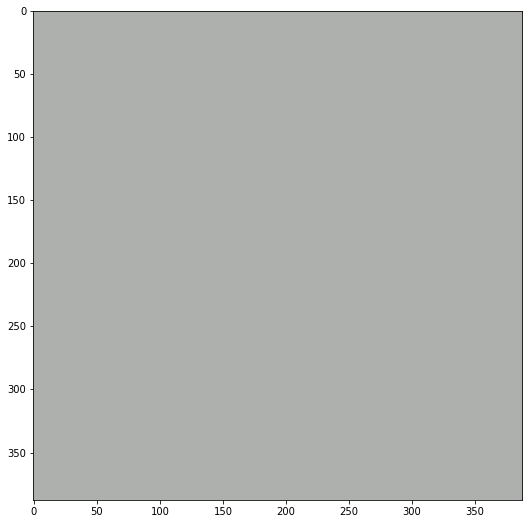

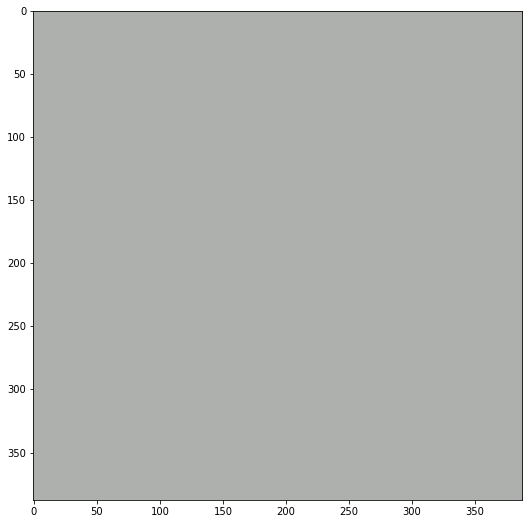

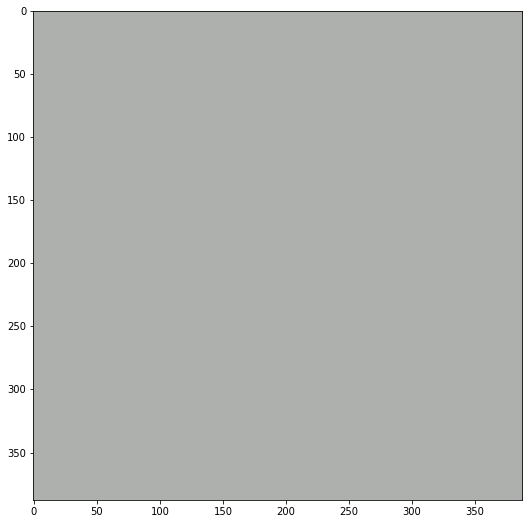

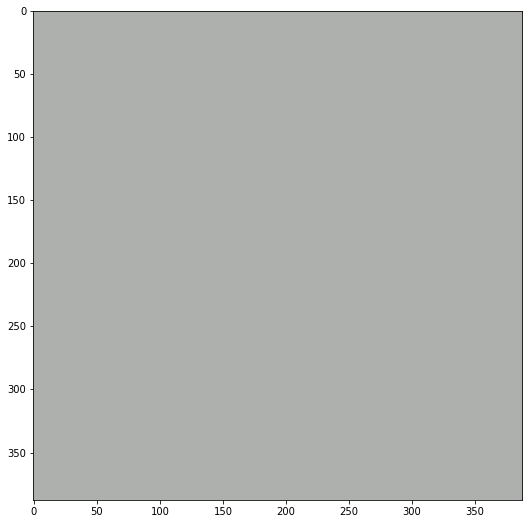

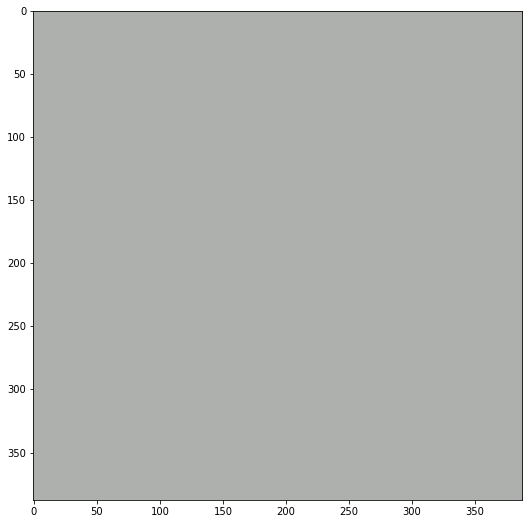

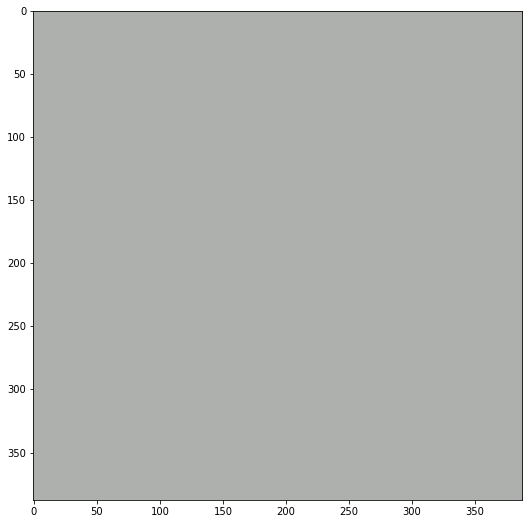

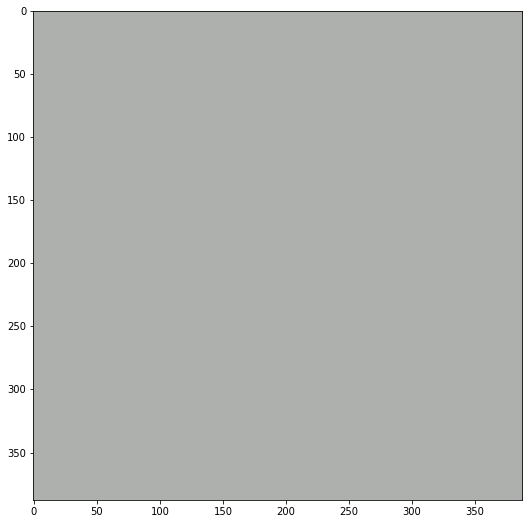

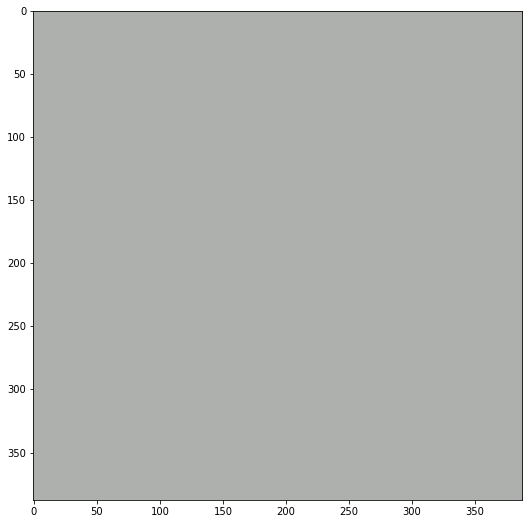

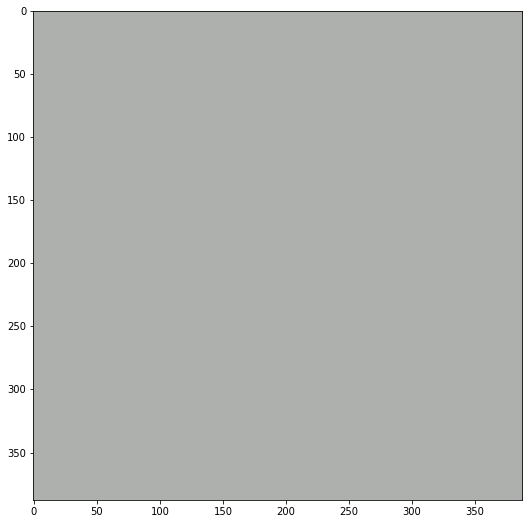

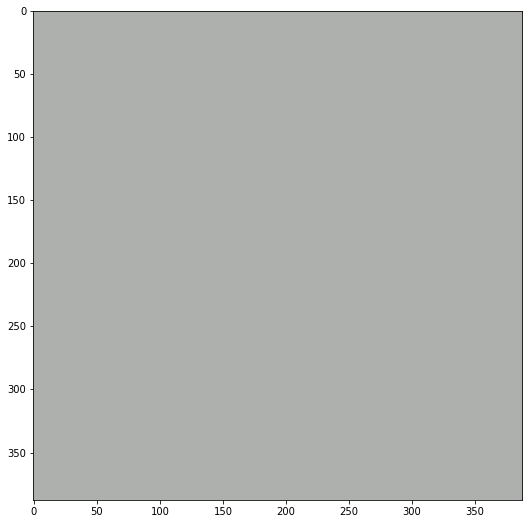

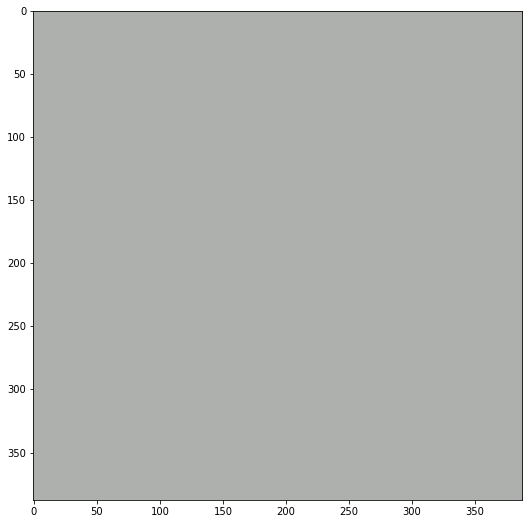

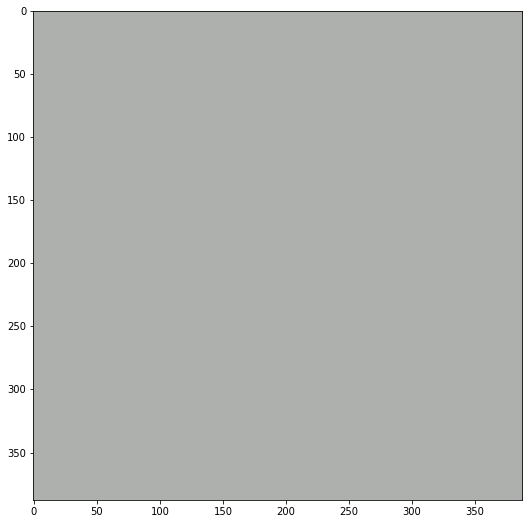

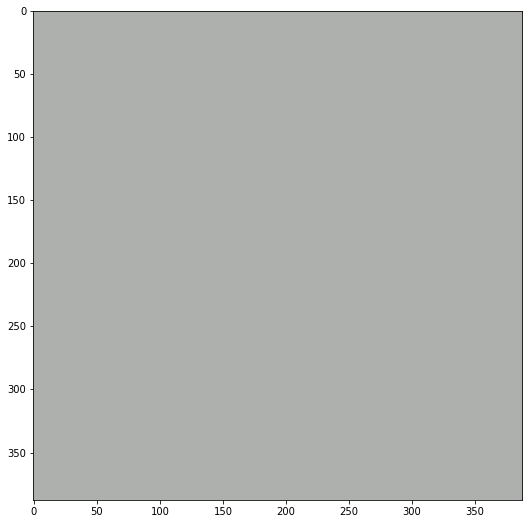

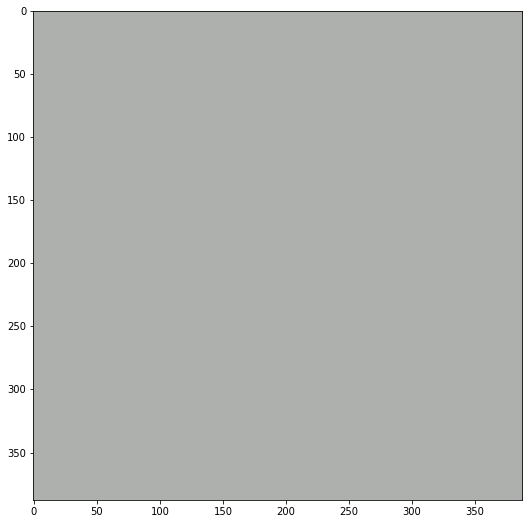

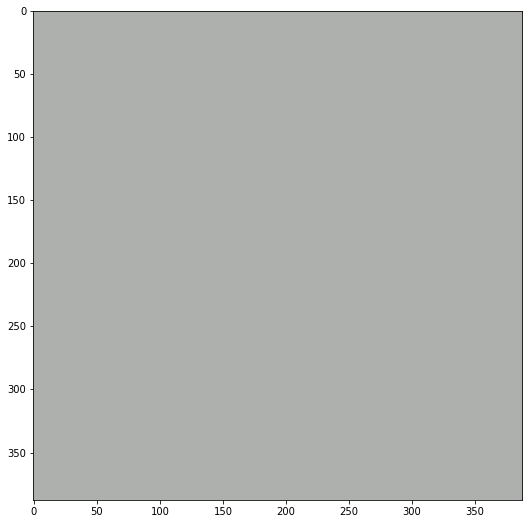

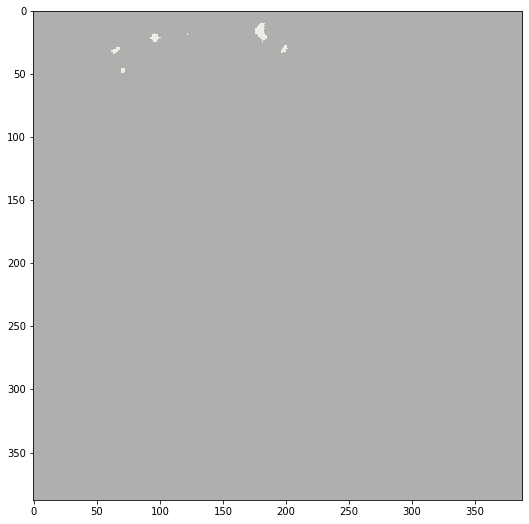

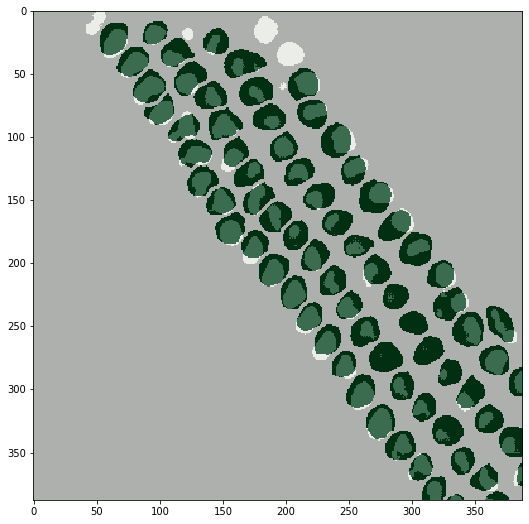

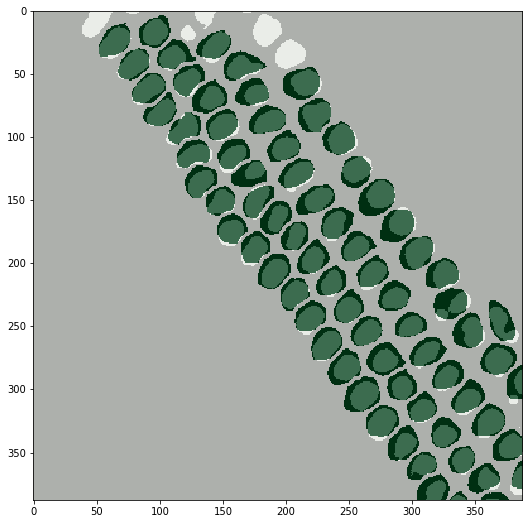

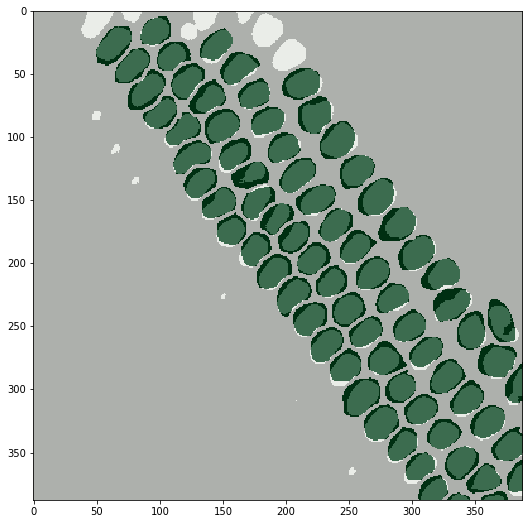

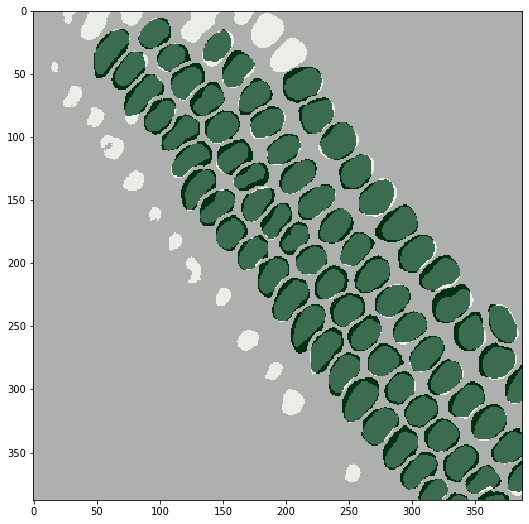

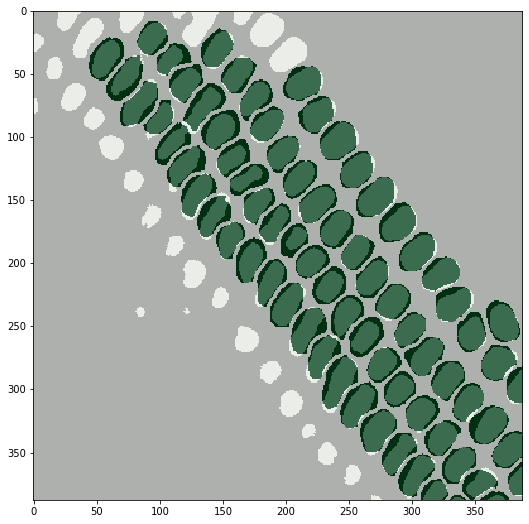

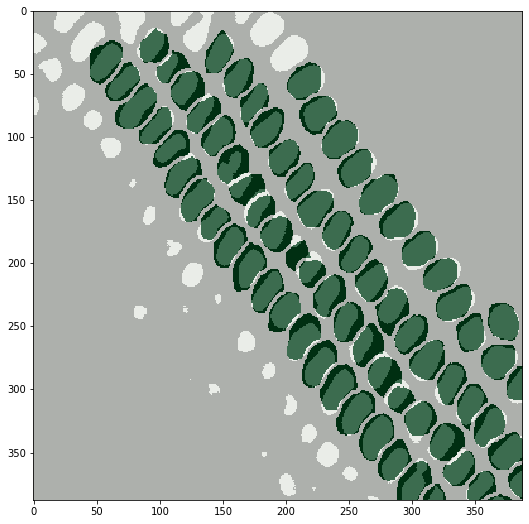

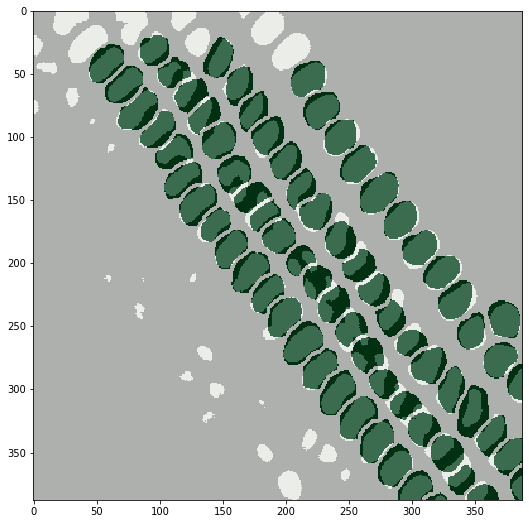

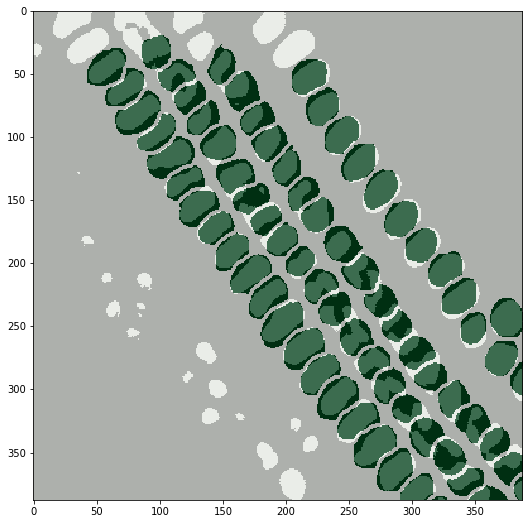

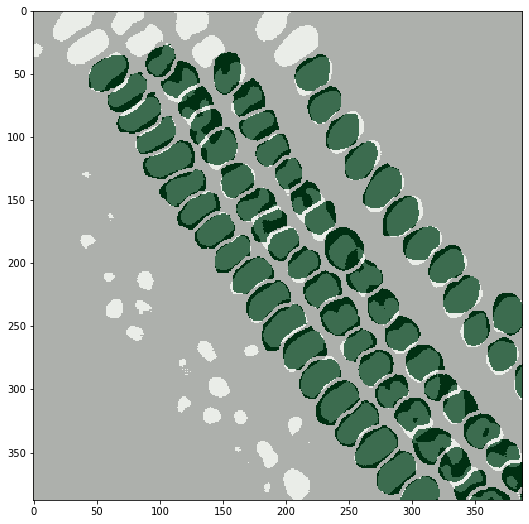

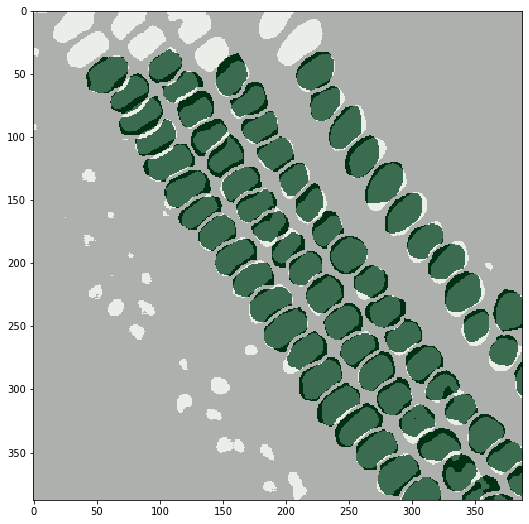

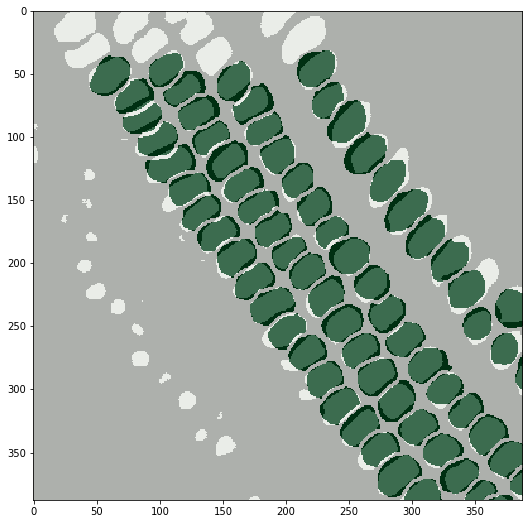

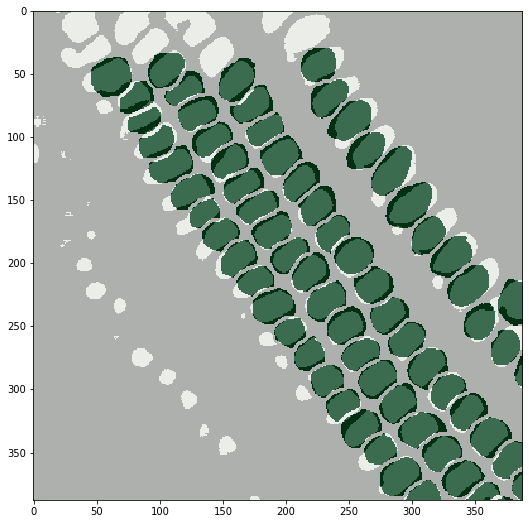

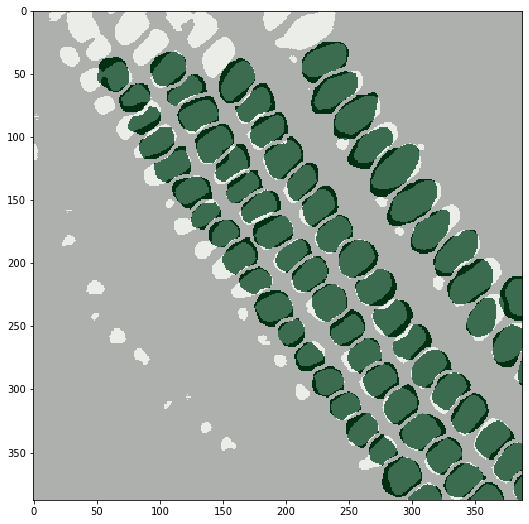

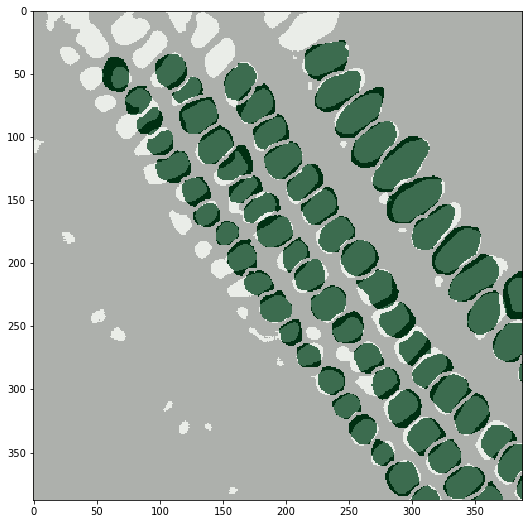

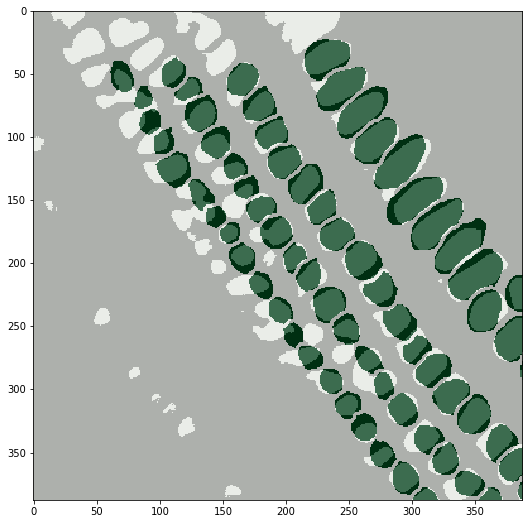

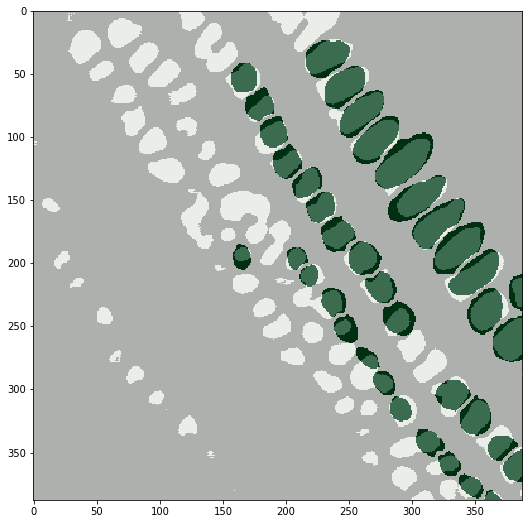

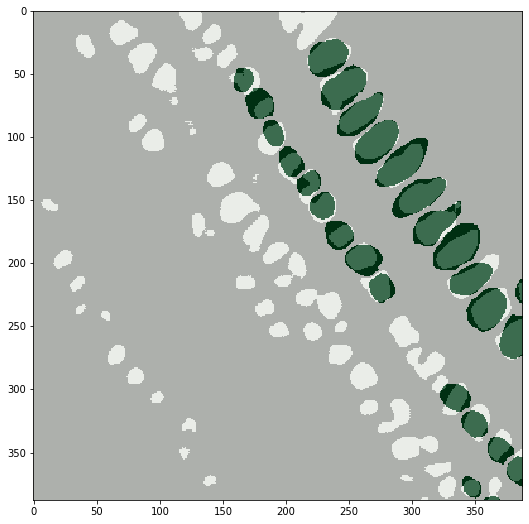

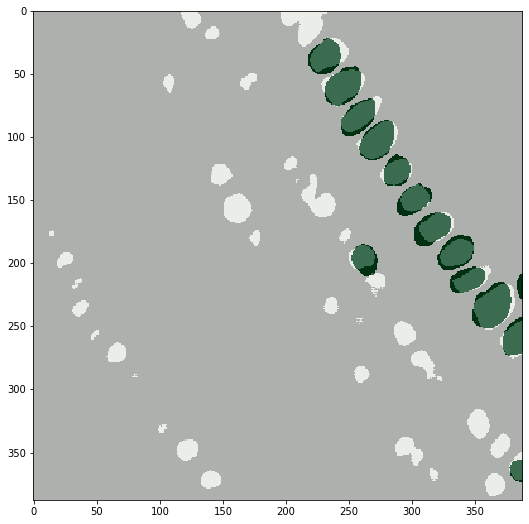

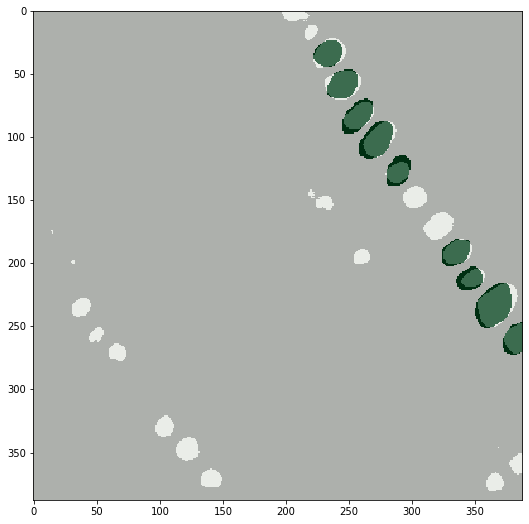

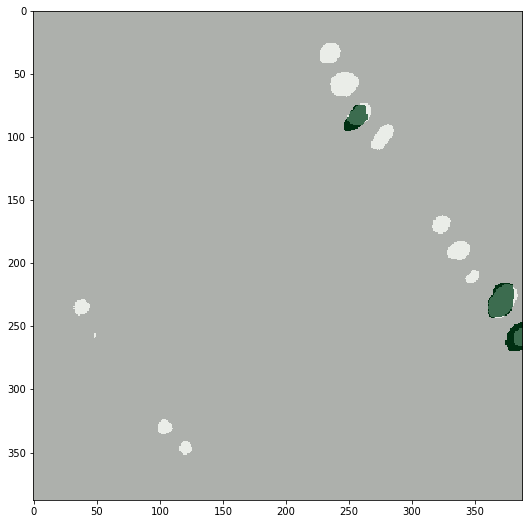

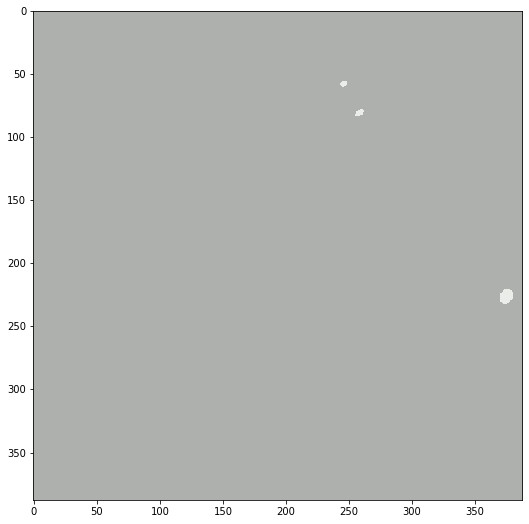

IndexError: index 37 is out of bounds for dimension 4 with size 37

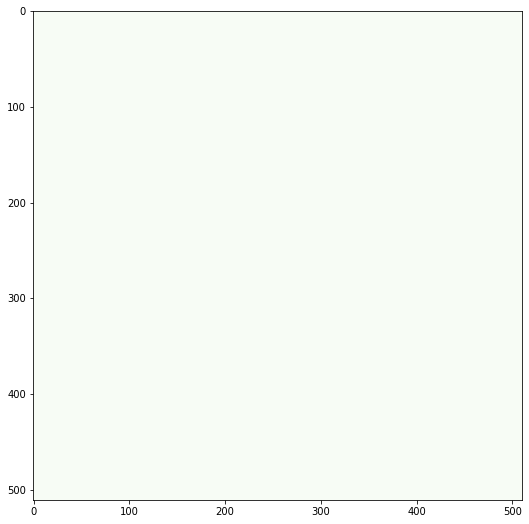

In [10]:
image, mask, pwl  = val_data[0]
#test.eval()
#test.cpu()
with torch.no_grad(): 
    out = test(image.float().cuda())

pred = F.sigmoid(out) > .5
for i in range(image.shape[-1]):
    plt.figure(figsize=(9,9))
    #plt.imshow(image[0,[0,2,1],:,:,i].float().transpose(0,1).transpose(1,2)*.5 + .5)
    #plt.imshow(image[0,0:3,:,:,i].float().transpose(0,1).transpose(1,2)*.5 + .5)
    plt.imshow(mask[0,0,:,:,i].float(), cmap = 'Greens')
    plt.imshow(pred[0,0,:,:,i].cpu().detach().numpy(), cmap=plt.cm.nipy_spectral,alpha=.3)
    plt.show()


In [ ]:
torch.cuda.empty_cache()